# Basic Models in TensorFlow 

## Linear regression in TensorFlow
- Model the linear relationship between
    + dependent variable Y, explanatory variables X 
    + Find a linear relationship between X and Y to predict Y from X 
- Inference: Y_predicted = w * X +b

### Linear Regression with huber loss by low-level
- Huber loss 
    + Robust to ouliers 
    + If the difference between the predicted value and the real value is small, square it
    + If it's large, take its absolute value
- Implementing Huber loss 
    + tf.cond(pred, fn1, fn2, name=None)

#### Setup 

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

1.11.0


#### Load and Pre-process data 

In [2]:
# Read in data
data = pd.read_table('../data/birth_life_2010.txt')
data.head()

,Country,Birth rate,Life expectancy
0,Vietnam,1.822,74.828244
1,Vanuatu,3.869,70.819488
2,Tonga,3.911,72.150659
3,Timor-Leste,5.578,61.999854
4,Thailand,1.579,73.927659


In [3]:
x = data.loc[:, 'Birth rate'].values
y = data.loc[:, 'Life expectancy'].values
print(x.shape, y.shape)

(190,) (190,)


In [4]:
# Split train and validation 
# 190개에서 0.7= 133개 선택(idex)
tr_indices = np.random.choice(range(x.shape[0]), size = int(x.shape[0] * .7), replace=False)
print('tr_indices: {}'.format(tr_indices))

tr_indices: [136   4   6 111  93 141  96  59 140  40  83  17 178 134 175   5  50 183
 145  98  46 159  87  10  42  94  88  81  36  43  11  33 106  90 105 187
  66 100  61  65 128 152  91   8  13 114  63  70  95 155 102 160 165  75
  29 104  14  38 121  19  79  47 107  28 146 129 172 101 135 151  69  56
 177  60  16  31 180 125  20  12  67  76 148  99  74 144  35 119 168 158
  68  64 157  58  62 166 116   0  32  48 188   1   9  30 162  24 120  44
 179  54 174   7 185 122 139 118  49 143  23 154  85  39 130  21 109 156
 186 133 171 137  22 150  34]


In [5]:
x_tr = x[tr_indices]
y_tr = y[tr_indices]

x_val = np.delete(x, tr_indices, axis=0)
y_val = np.delete(y, tr_indices, axis=0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(133,) (133,)
(57,) (57,)


#### Define the graph of Simple Linear Regression 

In [14]:
tf.reset_default_graph()

# Create placeholders for inputs(X, birth rate) and labels(Y, life expectancy)
X = tf.placeholder(dtype=tf.float32, shape=[None], name='input')
Y = tf.placeholder(dtype=tf.float32, shape=[None], name='label')

# Createweight and bias
w = tf.get_variable(name='weight', initializer=tf.constant(.0))
b = tf.get_variable(name='bias', initializer=tf.constant(.0))

# Inference: Construct model to predict Y
y_predicted = X * w + b

# Specify loss function
# Use the square error as huber loss function
residual = tf.abs(Y - y_predicted)
huber_loss = tf.cond(tf.reduce_mean(residual) <= 14.,
                     lambda : .5 * tf.reduce_mean(tf.square(residual)),
                     lambda : 14. * tf.reduce_mean(residual) - .5 * tf.square(14.))
huber_loss_summ = tf.summary.scalar(name='huber_loss', tensor=huber_loss)
# Create optimizer
# Using gradient descent with learning rate of 0.01 to minimize loss 
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(huber_loss)

#### Training 
1. Initialize variables 
2. Run optimizer

In [10]:
epochs = 100
batch_size = 8
total_step = int(x.shape[0] / batch_size)
print(total_step)

23


In [12]:
train_writer = tf.summary.FileWriter(logdir='../graphs/lec03/linreg_huber_low_tf_placeholder/train',
                                    graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir='../graphs/lec03/linreg_huber_low_tf_placeholder/val',
                                  graph=tf.get_default_graph())

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):#epoch = 100
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):#total_step = 23 
        # batch_indices = 133개 중에 8개씩 
        batch_indices = np.random.choice(range(x_tr.shape[0]),
                                        size=batch_size, replace=False)
        val_indices = np.random.choice(range(x_val.shape[0]),
                                      size=batch_size, replace=False)
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches=[training_op, huber_loss],
                             feed_dict={X: batch_xs, Y: batch_ys})
        tr_loss_summ = sess.run(huber_loss_summ, feed_dict={X: batch_xs, Y: batch_ys})
        
        val_loss, val_loss_summ = sess.run(fetches=[huber_loss, huber_loss_summ],
                                         feed_dict={X: val_xs, Y: val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    train_writer.add_summary(tr_loss_summ, global_step=epoch)
    val_writer.add_summary(val_loss_summ, global_step=epoch)
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    if epoch % 10 == 0:
        print('epoch : {:3}, tr_loss: {:.2f}, val_loss: {:.2f}'.format(epoch, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch :   0, tr_loss: 661.91, val_loss: 662.36
epoch :  10, tr_loss: 313.32, val_loss: 313.08
epoch :  20, tr_loss: 220.44, val_loss: 233.86
epoch :  30, tr_loss: 175.07, val_loss: 148.35
epoch :  40, tr_loss: 124.32, val_loss: 100.15
epoch :  50, tr_loss: 66.44, val_loss: 61.22
epoch :  60, tr_loss: 35.81, val_loss: 36.86
epoch :  70, tr_loss: 19.41, val_loss: 25.31
epoch :  80, tr_loss: 17.15, val_loss: 19.38
epoch :  90, tr_loss: 11.89, val_loss: 16.92


#### Visualization

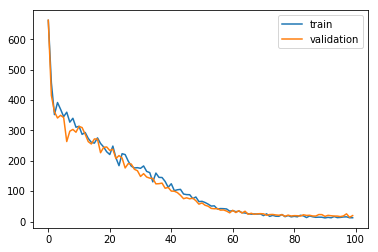

In [16]:
plt.plot(tr_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.legend()

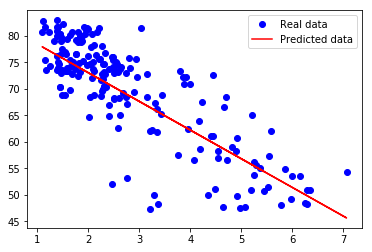

In [17]:
w_out, b_out = sess.run([w, b])
plt.plot(data.iloc[:,1], data.iloc[:,2], 'bo', label='Real data')
plt.plot(data.iloc[:,1], data.iloc[:,1] * w_out + b_out, 'r', label='Predicted data')
plt.legend()